In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


## Requirements

In [3]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 4.0 MB 34.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.8 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 895 kB 61.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch

In [6]:
MODELNAME = 'BioBERT'
DATASETNAME = 'BiodivRE'

In [7]:
MODEL_PATH = 'dmis-lab/biobert-base-cased-v1.1'

In [8]:
tokenizer_name = 'bert-base-cased'

In [9]:
num_train_epochs = 5

In [10]:
MODEL_PATH

'dmis-lab/biobert-base-cased-v1.1'

In [11]:
num_train_epochs

5

##Dataset Preprocessing


Dataset config file

In [12]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "BiodivRE")
print(root_data_dir)

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/BiodivRE


### Dataset Loading

Data loading utils

In [13]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  data = data.fillna(method="ffill")
  return data

In [14]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)

In [15]:
data_train.head(10)

,Label,Sentence
0,0,( species : species ) The @QUALITY$ are based ...
1,1,Almost half of the threatened species assessed...
2,0,"In 18 grazed and 21 improved fallows , we esti..."
3,0,BEF research plot where the abundance of @ORGA...
4,0,Indicators : Access to clean fuels and technol...
5,0,We demonstrate that I. noli- tangere and I. te...
6,0,Although its marine biota can be considered re...
7,0,We draw on a spatially-replicated dataset on A...
8,0,Ways to quantify @PHENOMENA$ : rainfall amount...
9,0,"In the light of the @QUALITY$ , it is of major..."


In [16]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)

In [17]:
data_test.head(10)

,Label,Sentence
0,1,( loss_f : average sandloss forest g m-2 -- --...
1,0,"In a grassland biodiversity experiment , we ad..."
2,0,Indicators : Access to clean fuels and technol...
3,1,The cbbL form IA and IC genes associated with ...
4,1,Microbial biomass and diversity increased in m...
5,0,DESCRIPTION Combined @ORGANISM$ Data SUMMARY T...
6,1,"@QUALITY$ ( rare_fg_se ) , dimensionless rare_..."
7,0,Indicators : Access to clean fuels and technol...
8,1,Our results show that existing @ENVIRONMENT$ i...
9,0,Indicators : Access to clean fuels and technol...


In [18]:
data_dev = loadData(csv_file_path='dev.csv', header=None, index_col=None)

In [19]:
data_dev.head(10)

,Label,Sentence
0,1,We hypothesized that ( i ) the food choice of ...
1,0,Ways to quantify precipitation : rainfall amou...
2,0,Potential areas for @PHENOMENA$ almost double ...
3,1,( CSP14 : BEF research plot where the @QUALITY...
4,1,-- - Crown length is calculated as the total t...
5,0,Spatiotemporal modulation of biodiversity in a...
6,0,Ways to quantify precipitation : rainfall amou...
7,0,( Age : the @QUALITY$ class assigned at the ti...
8,1,This system is an important model for understa...
9,0,Ways to quantify @PHENOMENA$ : rainfall amount...


In [20]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


split texts and labels

In [21]:
data_train.columns

Index(['Label', 'Sentence'], dtype='object')

In [22]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [23]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [24]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [25]:
plt.style.use("ggplot")

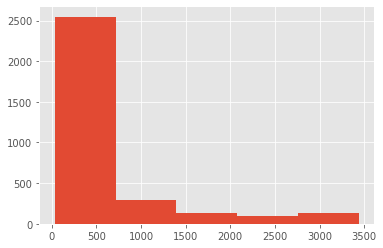

In [26]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [27]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

3442

In [28]:
max([len(s) for s in test_texts])

3436

In [29]:
max([len(s) for s in dev_texts])

3432

## Explicit Truncation

##BERT-Based Model

In [30]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast
print(tokenizer_name)
if 'dist' in tokenizer_name:
  tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_name)
else:
  tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)
  


bert-base-cased


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)

In [32]:
len(train_encodings[0])

128

### Dataset objects 

Create the dataset objects

In [33]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [34]:
# train_encodings.pop("offset_mapping") # we don't want to pass this to the model
# test_encodings.pop("offset_mapping")

In [35]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, dev_labels)
test_dataset = MyDataset(test_encodings, test_labels)

### Training

Here, we instantiate the model

In [36]:
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification
if 'dist' in MODELNAME:
  model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
else:
  model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

#### Fine-tuning using Trainer

In [37]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

In [38]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    # gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
  )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,      
    
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3200
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.571300,0.552660,0.702500
2,0.498100,0.470217,0.785000
3,0.385100,0.420496,0.825000
4,0.323300,0.455326,0.807500
5,0.298100,0.413931,0.800000


***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.4446198697090149, metrics={'train_runtime': 432.2639, 'train_samples_per_second': 37.014, 'train_steps_per_second': 1.157, 'total_flos': 1052444221440000.0, 'train_loss': 0.4446198697090149, 'epoch': 5.0})

### Save model

In [39]:
model.save_pretrained('{}_{}'.format(MODELNAME, DATASETNAME))

Configuration saved in BioBERT_BiodivRE/config.json
Model weights saved in BioBERT_BiodivRE/pytorch_model.bin


### Prediction

The use of validation dataset

In [40]:
eval_history = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


In [41]:
predictionsOutput = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 400
  Batch size = 8


In [42]:
predictionsOutput.predictions.shape

(400, 2)

In [43]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [44]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(400,)

Explore one example of the test dataset (prediction vs. true) lables.

In [45]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

1 ( loss_f : average sandloss forest g m-2 -- -- ) real Deriving kinetic energy from @PHENOMENA$ @QUALITY$ is derived from sand loss out of splashcups .
1 ( loss_f : average sandloss forest g m-2 -- -- ) real Deriving kinetic energy from @PHENOMENA$ @QUALITY$ is derived from sand loss out of splashcups .


### Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [46]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [47]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.81


In [48]:
from sklearn.metrics import precision_recall_fscore_support

In [49]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([0.89565217, 0.69411765]),
 array([0.79844961, 0.83098592]),
 array([0.8442623 , 0.75641026]),
 array([258, 142]))

In [50]:
from classification_metrics import classification_report

In [51]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.90		 0.80		 0.84		 258	
                   1	 0.69		 0.83		 0.76		 142	


macro avg           	 0.79		 0.81		 0.80		 400	
micro avg           	 0.81		 0.81		 0.81		 400	



### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [52]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

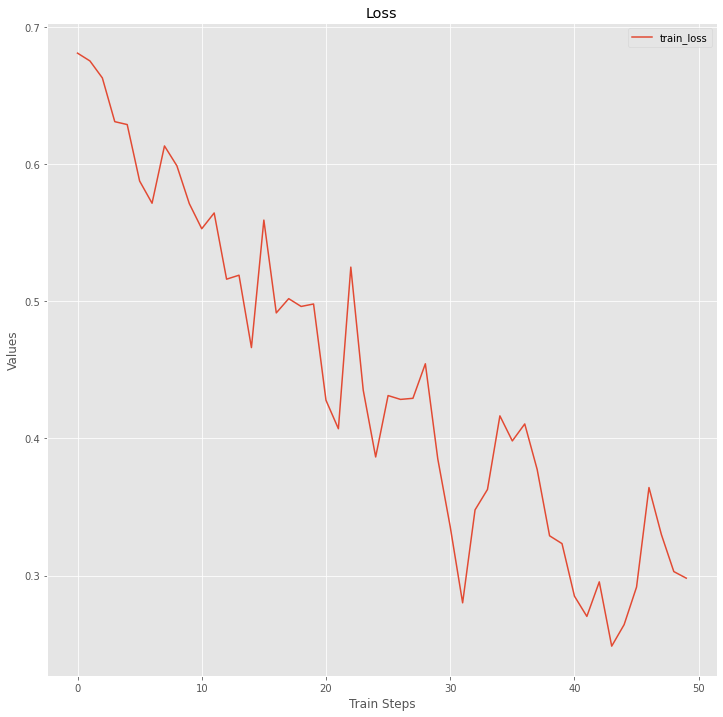

In [53]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    #loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [54]:
eval_history

{'epoch': 5.0,
 'eval_accuracy': 0.8,
 'eval_loss': 0.413930743932724,
 'eval_runtime': 3.3789,
 'eval_samples_per_second': 118.38,
 'eval_steps_per_second': 14.798}